# Final Project – Identifying Learner Personas from Platform Usage


## 1. Project Description
This project aims to analyze interaction data from a digital learning platform (Lernnavi) to uncover patterns in student engagement and behavior over time. By processing event-level data such as session frequency, timing, and duration, we seek to go beyond surface-level usage and model deeper behavioral tendencies.

The ultimate goal is to group students into distinct learner profiles (or personas), which can help inform personalized educational strategies and improve platform design.

We focus on temporal and interaction-based features that reflect how, when, and how regularly students engage with the learning platform. These data-driven insights can support better understanding of student needs and engagement patterns.

## 2. Research Questions

1. **What distinct learning behaviors can be identified based on time-based interaction patterns?**
2. **Can these behavioral patterns be used to meaningfully categorize students into different learner types?**


In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import colorcet as cc
import gc
import pickle
from utils.memory_usage import see_memory_usage
from functools import reduce

from utils.clustering_eval_utils import evaluate_model
from utils.clustering import *
from utils.feature_processing import *

DATA_DIR = './data/Lernnavi' # You may change the directory

## 3. Preprocessing


### 3.1 Data Segmentation into Time Windows


In [2]:
users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

In [3]:
events['action'].value_counts()


action
PAGE_VISIT              2113982
REVIEW_TASK             1734632
SUBMIT_ANSWER           1404142
NAVIGATE_DASHBOARD      1093791
NEXT                     907521
WINDOW_VISIBLE_FALSE     851634
WINDOW_VISIBLE_TRUE      705679
VIEW_QUESTION            451981
OPEN_FEEDBACK            281632
CLOSE_FEEDBACK           251044
GO_TO_THEORY             211418
SUBMIT_SEARCH            162067
VIEW_SESSION_END         159925
SKIP                     158420
WINDOW_OPEN              150781
CLOSE                    131124
WINDOW_CLOSE             122121
LOGIN                    105144
SURVEY_BANNER             68655
SELECT_STATISTICS         57119
ACCEPT_PROGRESS           30996
GO_TO_COMMENTS            12158
GO_TO_BUG_REPORT           9772
LOGOUT                     6821
SHARE_SESSION              3320
REJECT_PROGRESS            3257
PRETEST                    1709
NAVIGATE_SURVEY            1111
GO_TO_SESSION               563
REQUEST_HINT                562
SHARE                        90
N

To focus on meaningful engagement, we filter the events table to retain only actions that reflect actual learning behavior. These include starting tasks (`REVIEW_TASK`), submitting answers (`SUBMIT_ANSWER`), progressing between tasks (`NEXT`, `SKIP`), reviewing results (`OPEN_FEEDBACK`), and accessing theory content (`GO_TO_THEORY`). This selection removes passive or technical events like page visits or tab visibility changes, which do not contribute to behavioral modeling.


In [4]:
# Define relevant learning-related actions
relevant_actions = [
    "REVIEW_TASK",
    "SUBMIT_ANSWER",
    "NEXT",
    "SKIP",
    "OPEN_FEEDBACK",
    "GO_TO_THEORY"
]

# Filter the events table to keep only these
filtered_events = events[events['action'].isin(relevant_actions)].copy()

In [6]:
# Convert timestamp to weekly buckets
filtered_events['event_date'] = pd.to_datetime(filtered_events['event_date'], errors='coerce')
filtered_events['week'] = filtered_events['event_date'].dt.isocalendar().week
filtered_events['year'] = filtered_events['event_date'].dt.isocalendar().year

# Combine year + week to ensure correct ordering across years
filtered_events['year_week'] = filtered_events['event_date'].dt.strftime('%Y-%U')

# Preview: group activity per user-week
weekly_activity = (
    filtered_events.groupby(['user_id', 'year_week'])
    .agg(
        session_count=('session_id', 'nunique'),
        action_count=('event_id', 'count'),
        unique_actions=('action', 'nunique')
    )
    .reset_index()
)

weekly_activity.head()

,user_id,year_week,session_count,action_count,unique_actions
0,387604,2021-26,2,7,1
1,387604,2021-33,1,19,2
2,387604,2021-34,0,50,1
3,387604,2021-35,3,146,4
4,387604,2021-36,2,30,2


#### Merging Transactions Data

We enrich the events with outcome data from the `transactions` table by merging on the `transaction_token`. This allows us to compute weekly metrics like correctness ratio and average task duration, providing a more complete picture of each student's engagement.


In [7]:
# Ensure datetime in transactions
transactions['start_time'] = pd.to_datetime(transactions['start_time'], errors='coerce')
transactions['commit_time'] = pd.to_datetime(transactions['commit_time'], errors='coerce')

# Compute task duration in seconds
transactions['task_duration'] = (transactions['commit_time'] - transactions['start_time']).dt.total_seconds()

# Clean invalid rows
transactions = transactions.dropna(subset=['transaction_token', 'evaluation', 'task_duration'])

# Merge events with transactions
events_tx = filtered_events.merge(
    transactions[['transaction_token', 'evaluation', 'task_duration']],
    on='transaction_token',
    how='left'
)

# Drop events without evaluation (no meaningful outcome)
events_tx = events_tx.dropna(subset=['evaluation'])

# Regenerate year_week if needed
events_tx['year_week'] = events_tx['event_date'].dt.strftime('%Y-%U')

# Extended weekly aggregation
weekly_activity = (
    events_tx.groupby(['user_id', 'year_week']).agg(
        session_count=('session_id', 'nunique'),
        action_count=('event_id', 'count'),
        unique_actions=('action', 'nunique'),
        avg_task_duration=('task_duration', 'mean'),
        correct_ratio=('evaluation', lambda x: (x == 'CORRECT').sum() / x.count())
    )
    .reset_index()
)

# Preview
weekly_activity.head()


,user_id,year_week,session_count,action_count,unique_actions,avg_task_duration,correct_ratio
0,387604,2021-35,1,2,2,16.5440,0.0
1,387604,2021-38,0,8,2,14.5365,0.0
2,387604,2021-39,0,4,2,14.6480,0.5
3,387604,2021-40,0,2,2,10.0670,0.0
4,387604,2021-42,0,2,2,27.1630,0.0


#### Weekly Aggregation of Learning Behavior

We group each user's learning events into weekly buckets to extract temporal patterns. For each user-week, we compute summary statistics including the number of sessions, actions, unique activity types, average task duration, and answer correctness. These features provide a compact, time-aligned representation of engagement behavior over time.

In [8]:
# Ensure datetime formats
filtered_events['event_date'] = pd.to_datetime(filtered_events['event_date'], errors='coerce')
transactions['start_time'] = pd.to_datetime(transactions['start_time'], errors='coerce')
transactions['commit_time'] = pd.to_datetime(transactions['commit_time'], errors='coerce')

# Compute task duration
transactions['task_duration'] = (transactions['commit_time'] - transactions['start_time']).dt.total_seconds()

# Drop invalid transactions
transactions = transactions.dropna(subset=['transaction_token', 'evaluation', 'task_duration'])

# Merge transactions with filtered events
events_tx = filtered_events.merge(
    transactions[['transaction_token', 'evaluation', 'task_duration']],
    on='transaction_token',
    how='left'
)

# Drop events without evaluation
events_tx = events_tx.dropna(subset=['evaluation'])

# Create calendar week string
events_tx['year_week'] = events_tx['event_date'].dt.strftime('%Y-%U')

# Weekly aggregation
weekly_activity = (
    events_tx.groupby(['user_id', 'year_week']).agg(
        session_count=('session_id', 'nunique'),
        action_count=('event_id', 'count'),
        unique_actions=('action', 'nunique'),
        avg_task_duration=('task_duration', 'mean'),
        correct_ratio=('evaluation', lambda x: (x == 'CORRECT').sum() / x.count())
    )
    .reset_index()
)

# Preview
weekly_activity.head()


,user_id,year_week,session_count,action_count,unique_actions,avg_task_duration,correct_ratio
0,387604,2021-35,1,2,2,16.5440,0.0
1,387604,2021-38,0,8,2,14.5365,0.0
2,387604,2021-39,0,4,2,14.6480,0.5
3,387604,2021-40,0,2,2,10.0670,0.0
4,387604,2021-42,0,2,2,27.1630,0.0


#### Sequence Transformation (Wide Format)

We convert the long-format weekly table into wide-format sequences, where each row represents a user and each column corresponds to a specific week. This transformation aligns all users along a common timeline, enabling time-series modeling using DTW, LSTM, or classical ML approaches.

In [9]:
# Optional: filter users with at least N weeks of activity
min_weeks = 5
valid_users = weekly_activity['user_id'].value_counts()
valid_users = valid_users[valid_users >= min_weeks].index
weekly_filtered = weekly_activity[weekly_activity['user_id'].isin(valid_users)]

# Pivot to wide format for 'action_count'
action_seq = weekly_filtered.pivot(index='user_id', columns='year_week', values='action_count')

# Fill missing weeks with 0 (or np.nan if preferred)
action_seq = action_seq.fillna(0)

# Sort weeks chronologically
action_seq = action_seq.reindex(sorted(action_seq.columns), axis=1)

# Preview
action_seq.head()


year_week,2021-20,2021-21,2021-22,2021-23,2021-24,2021-25,2021-26,2021-27,2021-28,2021-29,...,2022-49,2022-50,2022-51,2022-52,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06
user_id,,,,,,,,,,,,,,,,,,,,,
387604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0
387605,0.0,6.0,0.0,0.0,2.0,0.0,0.0,43.0,24.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,88.0,0.0,0.0,0.0,0.0,37.0,0.0,0.0,0.0
387644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.0,0.0


In [10]:
# Example: stacking all into a dict
features = ['action_count', 'correct_ratio', 'avg_task_duration']
seq_dict = {}

for feat in features:
    wide = weekly_filtered.pivot(index='user_id', columns='year_week', values=feat)
    wide = wide.reindex(sorted(wide.columns), axis=1).fillna(0)
    seq_dict[feat] = wide


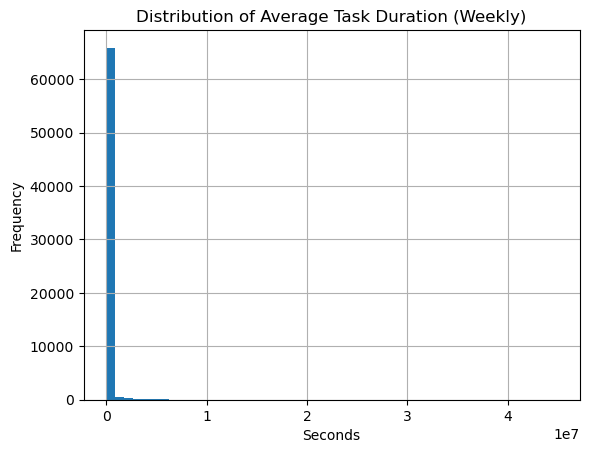

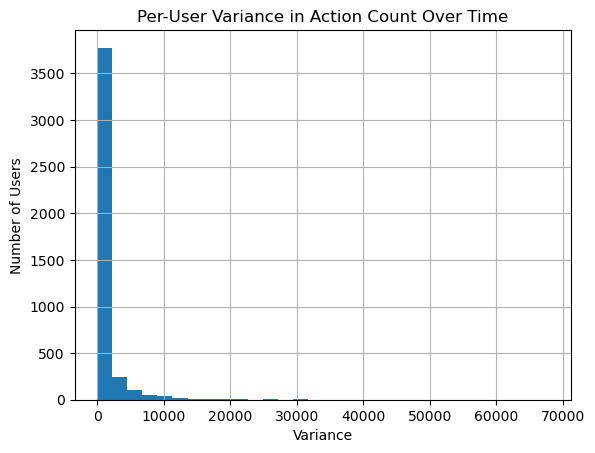

In [11]:
import matplotlib.pyplot as plt

# Plot distribution of a feature (e.g., avg task duration)
weekly_activity['avg_task_duration'].hist(bins=50)
plt.title("Distribution of Average Task Duration (Weekly)")
plt.xlabel("Seconds")
plt.ylabel("Frequency")
plt.show()

# Optional: check per-user temporal variance
action_var = action_seq.var(axis=1)
action_var.hist(bins=30)
plt.title("Per-User Variance in Action Count Over Time")
plt.xlabel("Variance")
plt.ylabel("Number of Users")
plt.show()


#### Outlier Handling and Sequence Quality Filtering

We observed extreme values in task duration and low behavioral variance in many user sequences. To ensure robust modeling, we cap average task durations and remove users with flat sequences that offer little temporal signal.

In [12]:
# Cap task durations at 1 hour (3600 seconds)
weekly_activity['avg_task_duration'] = weekly_activity['avg_task_duration'].clip(upper=3600)

# Pivot action_count again after cleaning
action_seq = weekly_activity.pivot(index='user_id', columns='year_week', values='action_count').fillna(0)

# Compute per-user variance
user_variance = action_seq.var(axis=1)

# Filter users with variance > threshold (e.g., 5 actions)
min_var = 5
valid_users = user_variance[user_variance > min_var].index
action_seq = action_seq.loc[valid_users]


### 3.2 Feature Engineering (RQ1): Temporal Behavior Vectors


#### Constructing Multivariate Sequences

To capture multiple dimensions of learning behavior over time, we build multivariate sequences for each user. Each sequence includes weekly values of selected features such as action count, correctness ratio, and average task duration. These sequences will serve as input to our clustering and prediction models.

In [13]:
# Feature list to include in the sequence
feature_list = ['action_count', 'correct_ratio', 'avg_task_duration']

# Prepare empty dict to store wide-format DataFrames
seq_dict = {}

# Ensure consistent users and weeks
weekly_activity['year_week'] = weekly_activity['year_week'].astype(str)
common_users = set(weekly_activity['user_id'])

# Create pivot tables for each feature
for feat in feature_list:
    df = weekly_activity.pivot(index='user_id', columns='year_week', values=feat).fillna(0)
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.loc[df.index.isin(common_users)]
    seq_dict[feat] = df

# Stack into a 3D array: (n_users, n_weeks, n_features)
import numpy as np

users = list(seq_dict[feature_list[0]].index)
weeks = list(seq_dict[feature_list[0]].columns)

sequence_tensor = np.stack([seq_dict[feat].loc[users].values for feat in feature_list], axis=-1)

# Check shape
print("Sequence tensor shape (users, weeks, features):", sequence_tensor.shape)


Sequence tensor shape (users, weeks, features): (21433, 92, 3)


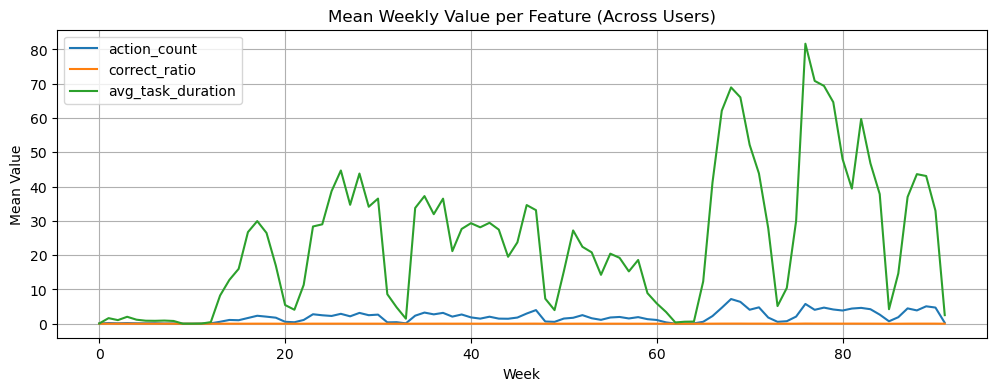

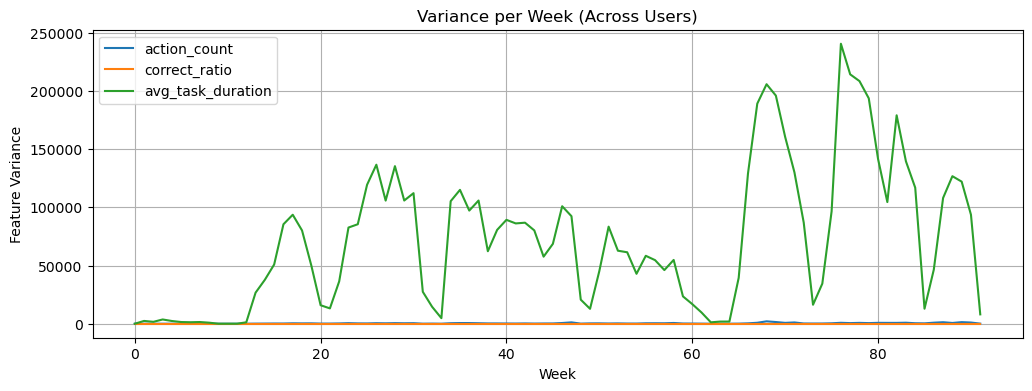

In [14]:
import matplotlib.pyplot as plt
import numpy as np

feature_names = ['action_count', 'correct_ratio', 'avg_task_duration']

# Mean over users (axis=0) → shape (weeks, features)
mean_over_users = sequence_tensor.mean(axis=0)
var_over_users = sequence_tensor.var(axis=0)

# Plot means per feature across weeks
plt.figure(figsize=(12, 4))
for i, name in enumerate(feature_names):
    plt.plot(mean_over_users[:, i], label=name)
plt.title("Mean Weekly Value per Feature (Across Users)")
plt.xlabel("Week")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True)
plt.show()

# Plot variance per feature across users
plt.figure(figsize=(12, 4))
for i, name in enumerate(feature_names):
    plt.plot(var_over_users[:, i], label=name)
plt.title("Variance per Week (Across Users)")
plt.xlabel("Week")
plt.ylabel("Feature Variance")
plt.legend()
plt.grid(True)
plt.show()


#### Slope Features (Trend Over Time)

Capture engagement evolution:

In [15]:
from scipy.stats import linregress

def compute_slope(sequence):
    x = np.arange(len(sequence))
    return linregress(x, sequence).slope

slopes = {
    name: np.apply_along_axis(compute_slope, axis=1, arr=sequence_tensor[:, :, i])
    for i, name in enumerate(feature_names)
}


#### Dropout Signal / Activity Gaps
Detect disengagement:





In [16]:
# Count trailing weeks with zero activity
def trailing_zeros(seq):
    return len(seq) - np.argmax(seq[::-1] > 0) if np.any(seq > 0) else len(seq)

dropout_signal = np.apply_along_axis(trailing_zeros, 1, action_seq.values)


#### Session-Based Features

### 3.3 Feature Engineering (RQ2): Early Prediction Features


### 3.4 Normalization, Imputation & Filtering


## 4. Modeling


### 4.1 Clustering for RQ1 (DTW, Spectral, HMM)


### 4.2 Supervised Prediction for RQ2 (RF, LR, LSTM)


## 5. Evaluation


### 5.1 Clustering Evaluation (Silhouette, DBI)


### 5.2 Prediction Evaluation (ROC-AUC, Precision, Recall, F1)


## 6. Conclusion
- Summary of insights
- Next steps